# Prediksi Harga Bitcoin Menggunakan Algoritma LSTM



## Import Library

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np

# scaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# modelling
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# visualization

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## Data Fecther

In [ ]:
def get_bitcoin_data(start_date, end_date):
  data = yf.Ticker('BTC-USD')
  df = data.history(start=start_date, end=end_date)
  return df

start_date = input('Masukkan tanggal mulai (format YYY-MM-DD):')
end_date = input('Masukkan tanggal akhir (format YYYY-MM-DD):')

data_bitcoin = get_bitcoin_data(start_date, end_date)
data_bitcoin.to_csv(f'bitcoin_{start_date}_to_{end_date}.csv')
print(data_bitcoin.head())

Masukkan tanggal mulai (format YYY-MM-DD):2018-06-10
Masukkan tanggal akhir (format YYYY-MM-DD):2024-06-10
                                  Open         High          Low        Close  \
Date                                                                            
2018-06-10 00:00:00+00:00  7499.549805  7499.549805  6709.069824  6786.020020   
2018-06-11 00:00:00+00:00  6799.290039  6910.180176  6706.629883  6906.919922   
2018-06-12 00:00:00+00:00  6905.819824  6907.959961  6542.080078  6582.359863   
2018-06-13 00:00:00+00:00  6596.879883  6631.660156  6285.629883  6349.899902   
2018-06-14 00:00:00+00:00  6342.750000  6707.140137  6334.459961  6675.350098   

                               Volume  Dividends  Stock Splits  
Date                                                            
2018-06-10 00:00:00+00:00  5804839936        0.0           0.0  
2018-06-11 00:00:00+00:00  4745269760        0.0           0.0  
2018-06-12 00:00:00+00:00  4654380032        0.0           0.0  


In [ ]:
df = pd.read_csv(f'bitcoin_{start_date}_to_{end_date}.csv')
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2018-06-10 00:00:00+00:00,7499.549805,7499.549805,6709.069824,6786.020020,5804839936,0.0,0.0
1,2018-06-11 00:00:00+00:00,6799.290039,6910.180176,6706.629883,6906.919922,4745269760,0.0,0.0
2,2018-06-12 00:00:00+00:00,6905.819824,6907.959961,6542.080078,6582.359863,4654380032,0.0,0.0
3,2018-06-13 00:00:00+00:00,6596.879883,6631.660156,6285.629883,6349.899902,5052349952,0.0,0.0
4,2018-06-14 00:00:00+00:00,6342.750000,6707.140137,6334.459961,6675.350098,5138710016,0.0,0.0


## Data Cleaning

In [ ]:
# mengubah kolom date menjadi tipe datetime
df['Date'] = pd.to_datetime(df['Date'])

# menghilangkan waktu dari kolom date
df['Date'] = df['Date'].dt.date

# set date as index
df = df.set_index('Date')

In [ ]:
# menghapus kolom yang tidak diperlukan
df = df.drop(['Dividends', 'Stock Splits'], axis=1)
df

,Open,High,Low,Close,Volume
Date,,,,,
2018-06-10,7499.549805,7499.549805,6709.069824,6786.020020,5804839936
2018-06-11,6799.290039,6910.180176,6706.629883,6906.919922,4745269760
2018-06-12,6905.819824,6907.959961,6542.080078,6582.359863,4654380032
2018-06-13,6596.879883,6631.660156,6285.629883,6349.899902,5052349952
2018-06-14,6342.750000,6707.140137,6334.459961,6675.350098,5138710016
...,...,...,...,...,...
2024-06-05,70568.351562,71735.414062,70390.710938,71082.820312,32810771409
2024-06-06,71082.843750,71625.734375,70119.125000,70757.164062,25223152007
2024-06-07,70759.187500,71907.851562,68507.257812,69342.585938,36188381096


In [ ]:
df.shape

(2192, 5)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2192 entries, 2018-06-10 to 2024-06-09
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2192 non-null   float64
 1   High    2192 non-null   float64
 2   Low     2192 non-null   float64
 3   Close   2192 non-null   float64
 4   Volume  2192 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 102.8+ KB


In [ ]:
df.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

## EDA

### High and Low

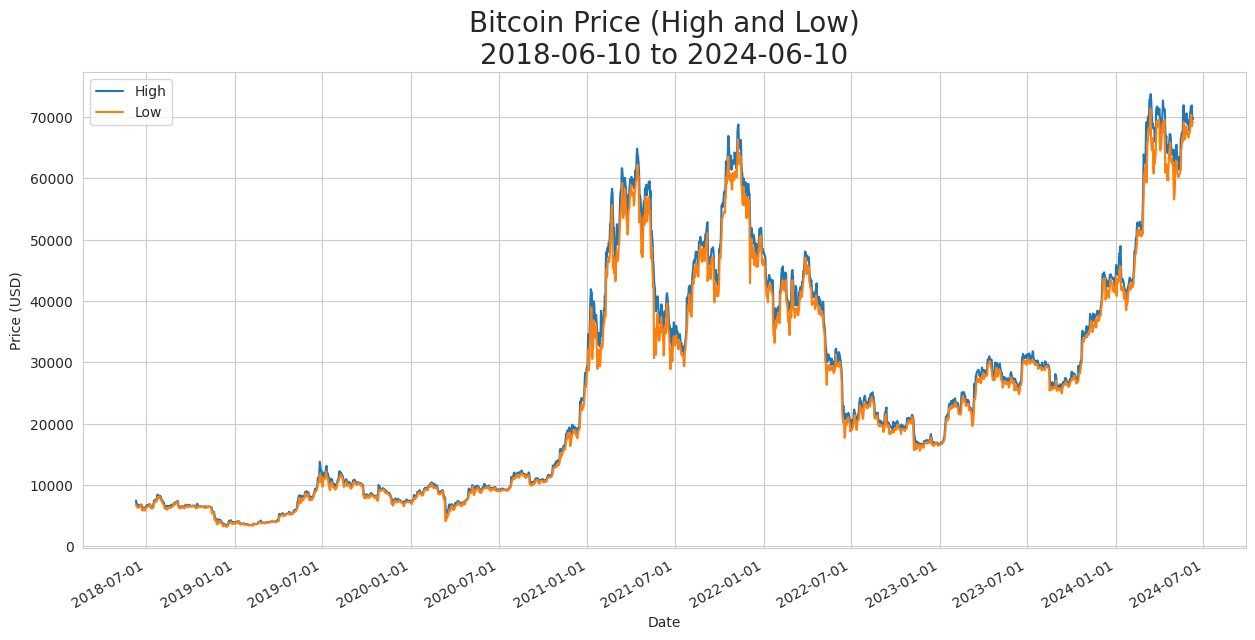

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(15, 7))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
x_dates = df.index.values

plt.plot(x_dates, df['High'], label='High')
plt.plot(x_dates, df['Low'], label='Low')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title(f'Bitcoin Price (High and Low)\n{start_date} to {end_date}', fontsize = 20)
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

### Open and Close

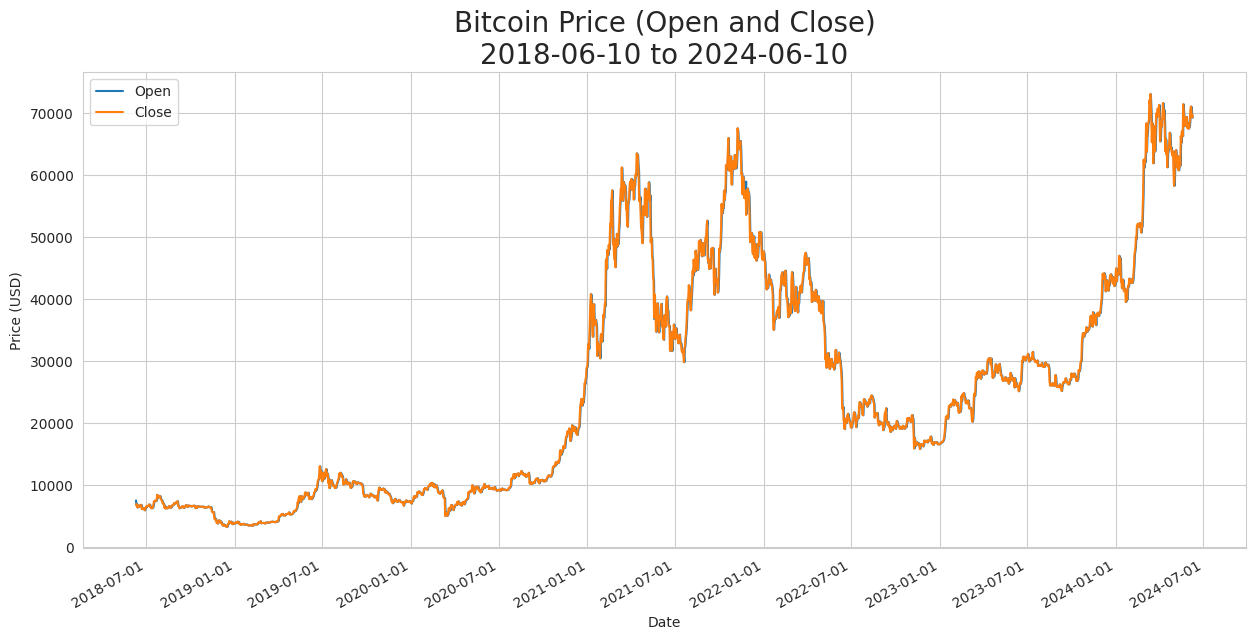

In [ ]:
plt.figure(figsize=(15, 7))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))

plt.plot(x_dates, df['Open'], label='Open')
plt.plot(x_dates, df['Close'], label='Close')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title(f'Bitcoin Price (Open and Close)\n{start_date} to {end_date}', fontsize = 20)
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

### Close

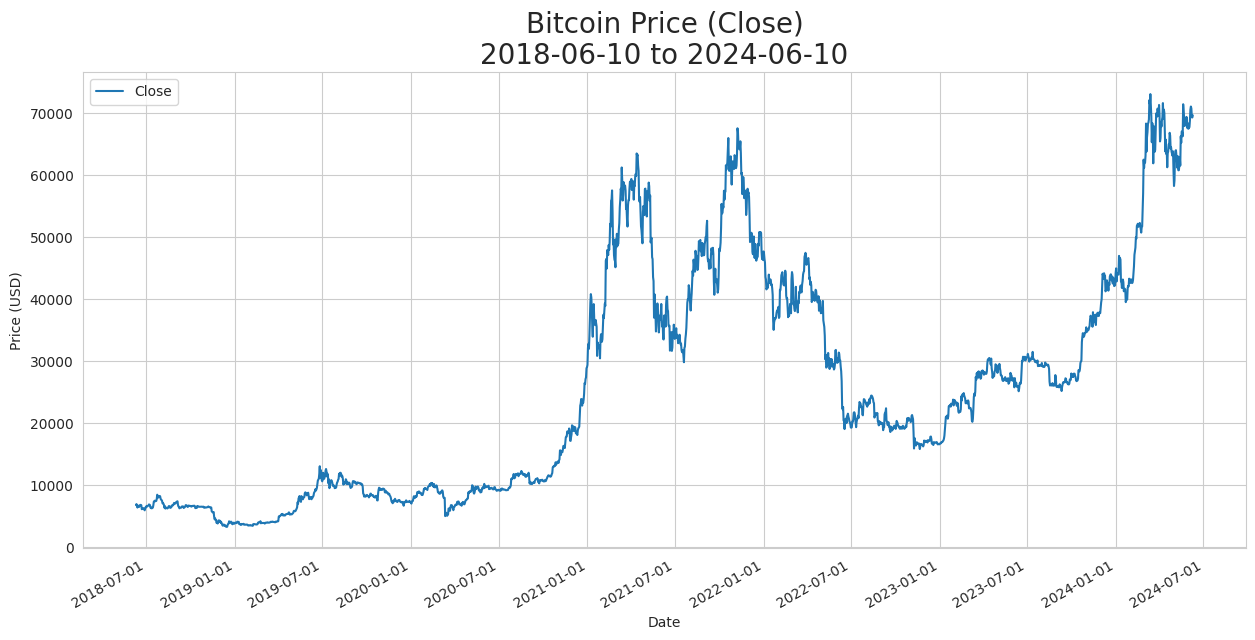

In [ ]:
plt.figure(figsize=(15, 7))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))

plt.plot(x_dates, df['Close'], label='Close')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title(f'Bitcoin Price (Close)\n{start_date} to {end_date}', fontsize = 20)
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

## Data Preprocessing

### Normalization

In [ ]:
# MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df['Close_ms'] = scaler.fit_transform(df[['Close']])

### Split Data

In [ ]:
def split_data(df, train_size):
  size = int(len(df) * train_size)
  train_data, test_data = df.iloc[0:size], df.iloc[size:len(df)]
  return train_data, test_data

In [ ]:
train_data, test_data = split_data(df['Close_ms'], 0.8)

### Visualization

Text(0.5, 1.0, 'Bitcoin Price\n80% Training and 20% Testing')

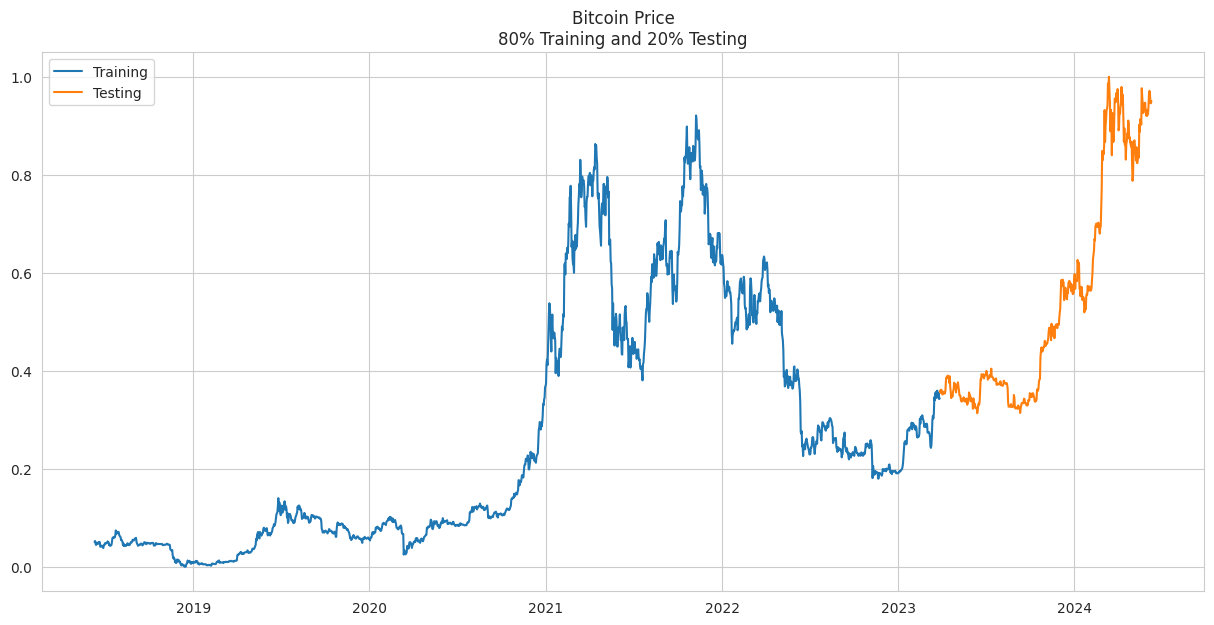

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(train_data)
plt.plot(test_data)
plt.legend(labels=['Training', 'Testing'])
plt.title('Bitcoin Price\n80% Training and 20% Testing')

## Create Datset for LSTM Model

In [ ]:
# Pembuatan dataset untuk LSTM
def create_dataset(df, timesteps=7):
  dataX, dataY = [], []
  for i in range(len(df)- timesteps):
    a = df[i:(i+timesteps),0]
    dataX.append(a)
    dataY.append(df[i+timesteps,0]) # menggunakan variabel Close sebagai target
  return np.array(dataX), np.array(dataY)

In [ ]:
X_train, y_train = create_dataset(train_data.values.reshape(len(train_data),1))
X_test, y_test = create_dataset(test_data.values.reshape(len(test_data),1))
X_train.shape,  y_train.shape, X_test.shape, y_test.shape

((1746, 7), (1746,), (432, 7), (432,))

In [ ]:
# Reshape Data (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0],  X_test.shape[1], 1))
X_train.shape, X_test.shape

((1746, 7, 1), (432, 7, 1))

## Build LSTM Model

In [ ]:
# callbacks
class Callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('val_mae') is not None and logs.get('val_mae') < 0.01:
      self.model.stop_training = True

In [ ]:
# Model architecture
model = Sequential()
model.add(LSTM(128,return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 7, 128)            66560     
                                                                 
 dropout_2 (Dropout)         (None, 7, 128)            0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 118081 (461.25 KB)
Trainable params: 118

In [ ]:
# Compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              metrics=['mae'],
              loss= tf.keras.losses.Huber())


## Training Model

In [ ]:
# Train model
history = model.fit(X_train,
                    y_train,
                    epochs=200,
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    shuffle=False,
                    callbacks=[Callback()])

Epoch 1/200
55/55 [==============================] - 5s 22ms/step - loss: 0.0259 - mae: 0.1520 - val_loss: 0.0262 - val_mae: 0.1918
Epoch 2/200
55/55 [==============================] - 0s 7ms/step - loss: 0.0074 - mae: 0.0973 - val_loss: 0.0016 - val_mae: 0.0488
Epoch 3/200
55/55 [==============================] - 0s 8ms/step - loss: 0.0046 - mae: 0.0841 - val_loss: 8.2004e-04 - val_mae: 0.0347
Epoch 4/200
55/55 [==============================] - 0s 7ms/step - loss: 0.0024 - mae: 0.0564 - val_loss: 5.6730e-04 - val_mae: 0.0257
Epoch 5/200
55/55 [==============================] - 0s 8ms/step - loss: 0.0013 - mae: 0.0378 - val_loss: 5.5685e-04 - val_mae: 0.0224
Epoch 6/200
55/55 [==============================] - 0s 8ms/step - loss: 0.0011 - mae: 0.0300 - val_loss: 6.2341e-04 - val_mae: 0.0257
Epoch 7/200
55/55 [==============================] - 0s 8ms/step - loss: 0.0010 - mae: 0.0276 - val_loss: 5.7548e-04 - val_mae: 0.0239
Epoch 8/200
55/55 [==============================] - 0s 8ms/st

### Visualization Training Result

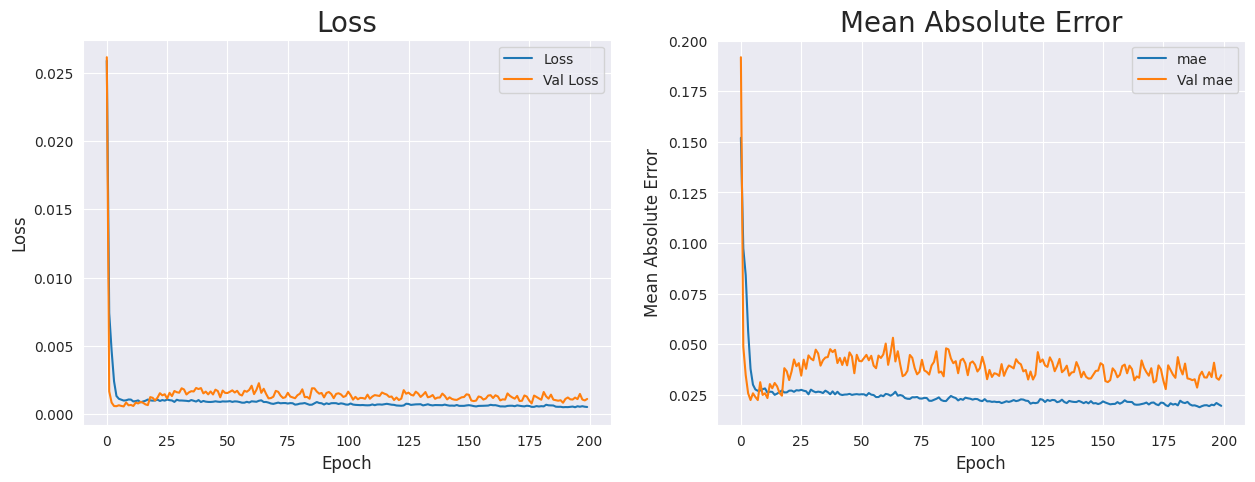

In [ ]:
sns.set_style('darkgrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# loss = huber
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['Loss', 'Val Loss'])
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Loss', fontsize=20)

# metrics = mae
ax2.plot(history.history['mae'])
ax2.plot(history.history['val_mae'])
ax2.legend(['mae', 'Val mae'])
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Mean Absolute Error', fontsize=12)
ax2.set_title('Mean Absolute Error', fontsize=20)

plt.show()

## Evaluation

In [ ]:
loss, mae = model.evaluate(X_test, y_test)
print('Loss:', loss)
print('MAE:', mae)

14/14 [==============================] - 0s 6ms/step - loss: 0.0011 - mae: 0.0347
Loss: 0.0010877432068809867
MAE: 0.03466049209237099


## Prediction

In [ ]:
# Prediksi Data Test
pred = model.predict(X_test)
y_pred = np.array(pred).reshape(-1)

14/14 [==============================] - 0s 3ms/step


In [ ]:
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = mean_absolute_percentage_error(y_test, y_pred)
print('MAE:', mae)
print('RMSE:', rmse)
print('MAPE:', mape)

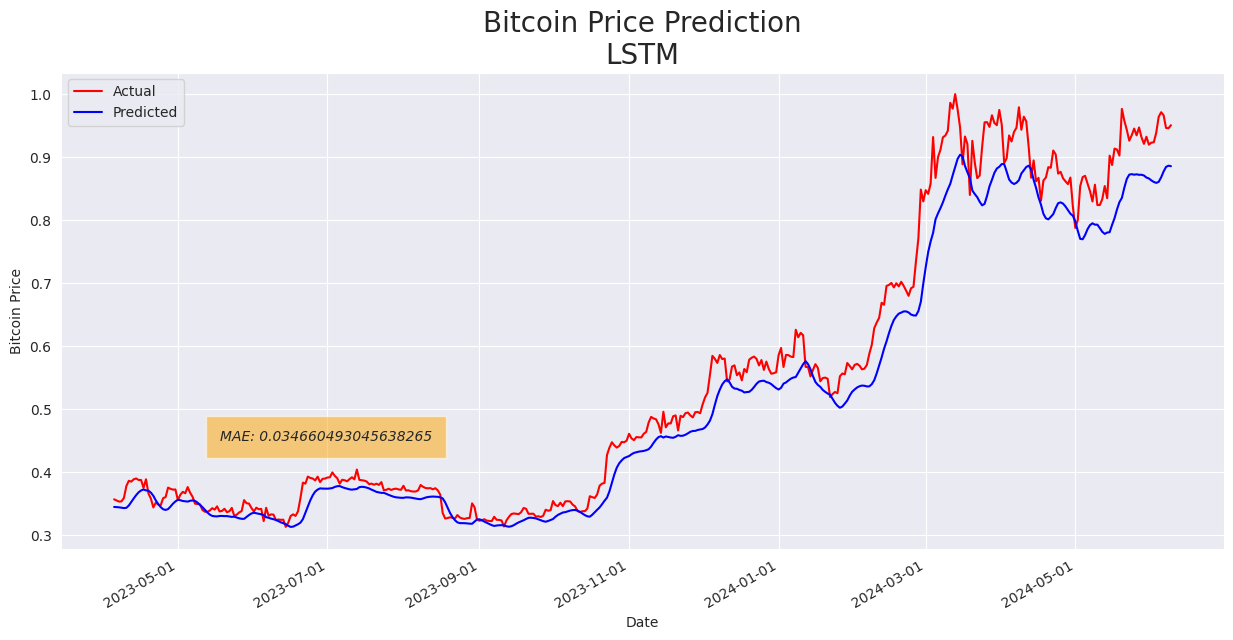

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(test_data.index[7:], y_test, color='red', label='Actual')
plt.plot(test_data.index[7:], y_pred, color='blue', label='Predicted')
plt.text(test_data.index[50], 0.45, f"MAE: {mean_absolute_error(y_test, y_pred)}", style='italic', bbox={'facecolor':'orange', 'alpha':0.5, 'pad':10})

plt.xlabel('Date')
plt.ylabel('Bitcoin Price')
plt.title('Bitcoin Price Prediction\nLSTM', fontsize = 20)
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()

## Visualization Prediction Results

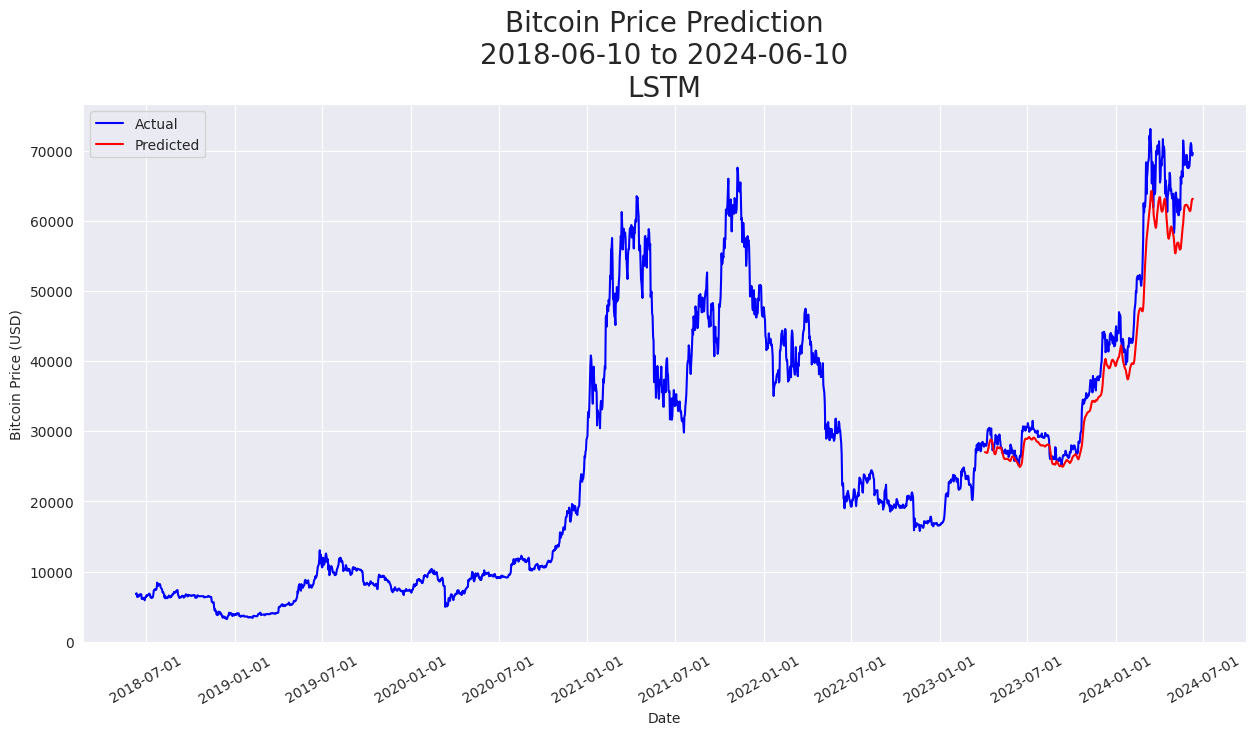

In [ ]:
# Inverse transform the predicted values
y_pred_original = scaler.inverse_transform(np.array(y_pred).reshape(-1, 1))

# Plot the actual and predicted prices
plt.figure(figsize=(15, 7))
plt.plot(df.index, df['Close'], color='blue', label='Actual')
plt.plot(df.index[-len(y_pred_original):], y_pred_original, color='red', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Bitcoin Price (USD)')
plt.title(f'Bitcoin Price Prediction\n{start_date} to {end_date}\nLSTM', fontsize=20)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
# Rotate x-axis labels
plt.xticks(rotation=30)

plt.legend()
plt.show()


## Save Prediction Results to CSV

In [ ]:
df_pred = pd.DataFrame({
    'Date': test_data.index[7:],
    'Actual': scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(-1),
    'Predicted': y_pred_original.reshape(-1)
})

In [ ]:
date = f'{start_date} to {end_date}'
df_pred.to_csv(f'bitcoin_prediction_{date}.csv')
print(f'File bitcoin_prediction_{date}.csv telah berhasil disimpan')

File bitcoin_prediction_2018-06-10 to 2024-06-10.csv telah berhasil disimpan
